In [444]:
# pull in, convert using datasheets, and prep all values for use in machine learning
# - plot data

#alphaTemp, prepped
#humidity, prepped
#temp, prepped
#light
#all stuff from forecast.io 
#windspeed from EPA
#windspeed from us, prepped
#other cheap sensors can be used to machine learn new sensor

%matplotlib inline
import matplotlib 
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt  
import pandas as pd
from dateutil import parser
import datetime
import pytz
import json

eastern = pytz.timezone('US/Eastern')
sns.set(style='ticks', palette='Set2')

def dateparse (timestamp):    
    return parser.parse(timestamp)


'''

TO CREATE EACH, DEFINE

ARRAY_TO_CREATE = 1-5

NEED TO CREATE 5 ML ARRAYS

(1) for smartcitizen CO and NO2 - 4/15-6/6 (1 min)
    -042516
    -052316
    -061316fullset

sck_mlarray.pkl


(2) for alphasense set1 CO, H2S, O3 - 4/15-5/23 (1 min)
    -042516
    -052316
    
as1_mlarray.pkl


(3) for alphasense set2 CO, O3, NO2 - 5/23-6/13 (1 min)
    -061316arduino (fullset for sck)

as2_mlarray.pkl


(4) for arduino wind and full temp/conditions array - 4/15-6/13 (1 min) 
(5) for arduino particulate - 4/15-6/13 (1 hr)
    -042516
    -052316
    -061316arduino (fullset for sck)

full_mlarray.pkl
pm_mlarray.pkl

'''

  
#pull data from csv into panda
sck1_min = pd.read_csv('/Users/davidramsay/Documents/thesis/arduinoDataSafe/cleanedData/takenDown042516/boxSmartCitizen042516_interpmin.csv', parse_dates=True, index_col=' UTC', header=0)
a1_min = pd.read_csv('/Users/davidramsay/Documents/thesis/arduinoDataSafe/cleanedData/takenDown042516/boxArduino042516_interpmin.csv', parse_dates=True, date_parser=dateparse, index_col='timestamp', header=0)
epa_ws_min = pd.read_csv('/Users/davidramsay/Documents/thesis/arduinoDataSafe/cleanedData/EPA/042516/ws042516.csv', parse_dates=True, index_col=0, skiprows=[0,1], names=['timestamp','wd','ws'])

sck2_min = pd.read_csv('/Users/davidramsay/Documents/thesis/arduinoDataSafe/cleanedData/takenDown052316/boxSmartCitizen052316_interpmin.csv', parse_dates=True, index_col=' UTC', header=0)
a2_min = pd.read_csv('/Users/davidramsay/Documents/thesis/arduinoDataSafe/cleanedData/takenDown052316/boxArduino052316_interpmin.csv', parse_dates=True, date_parser=dateparse, index_col='timestamp', header=0)
epa2_ws_min = pd.read_csv('/Users/davidramsay/Documents/thesis/arduinoDataSafe/cleanedData/EPA/052316/ws052316.csv', parse_dates=True, index_col=0, skiprows=[0,1], names=['timestamp','wd','ws'])

sck3_min = pd.read_csv('/Users/davidramsay/Documents/thesis/arduinoDataSafe/cleanedData/takenDown061316fullset/boxSmartCitizen061316_interpmin.csv', parse_dates=True, index_col=' UTC', header=0)
a3_min = pd.read_csv('/Users/davidramsay/Documents/thesis/arduinoDataSafe/cleanedData/takenDown061316arduino/boxArduino061316_interpmin.csv', parse_dates=True, date_parser=dateparse, index_col='timestamp', header=0)
epa3_ws_min = pd.read_csv('/Users/davidramsay/Documents/thesis/arduinoDataSafe/cleanedData/EPA/061316arduino/ws061316.csv', parse_dates=True, index_col=0, skiprows=[0,1], names=['timestamp','wd','ws'])

#add min since plugged in to each of these
a1_min['min_since_plugged_in'] = range(0, len(a1_min)) 
a2_min['min_since_plugged_in'] = range(0, len(a2_min)) 
a3_min['min_since_plugged_in'] = range(0, len(a3_min))

#concatenate into one array for each
arduino = pd.concat([a1_min, a2_min, a3_min])
sck = pd.concat([sck1_min, sck2_min, sck3_min])
epa_ws = pd.concat([epa_ws_min, epa2_ws_min, epa3_ws_min])
    
print len(epa_ws)
print len(sck)
print len(arduino)
print '---'
print len(a1_min)+len(a2_min)
print len(a3_min)
print len(sck3_min)

85739
74961
85739
---
55589
30150
19372


In [445]:
#concatenate into one array
fullset = pd.concat([arduino, sck, epa_ws], axis=1, join_axes=[arduino.index])
fullset.index = fullset.index.tz_localize(eastern)

#strip whitespace from column names
fullset.rename(columns=lambda x: x.strip(), inplace=True)

fullset.head()

,alphaS3_aux,pressureWind,alphaS1_aux,alphaS2_aux,sharpDust,alphaS3_work,alphaS2_work,alphaS1_work,alphaTemp,min_since_plugged_in,Battery ( %),Humidity ( % RAW),Noise ( mV),Temperature ( C RAW),Light ( lx),Nitrogen Dioxide ( kOhm),Carbon Monxide ( kOhm),Solar Panel ( V),wd,ws
timestamp,,,,,,,,,,,,,,,,,,,,
2016-04-15 06:13:00-04:00,177.000000,0.000000,984.000000,6.000000,817.000000,975.000000,975.000000,973.000000,62.000000,0,100.0,1454.000000,1.730000,2360.000000,368.900000,3.160000,145.490000,0.0,9,8.3
2016-04-15 06:14:00-04:00,68.054858,31067.307210,806.095592,5.330721,242.771158,261.446702,979.653605,977.322884,61.669279,1,100.0,1464.743323,2.308381,2344.436435,384.990488,4.277288,141.989471,0.0,41,5.7
2016-04-15 06:15:00-04:00,50.000000,31016.921631,273.470213,6.000000,210.751566,90.444356,983.673197,214.528990,61.673197,2,100.0,1494.698791,4.746435,2325.400806,408.593731,8.725112,118.436114,0.0,11,3.5
2016-04-15 06:16:00-04:00,49.000000,31011.520378,173.959244,6.000000,196.072104,70.062695,983.000000,121.833853,61.000000,3,100.0,1514.191098,1.609879,2311.520645,433.574098,11.559678,154.410894,0.0,13,3.0
2016-04-15 06:17:00-04:00,48.318966,30948.793120,131.215514,6.000000,198.043103,64.362069,983.318966,101.086206,61.000000,4,100.0,1527.844139,2.220749,2300.111329,458.366208,13.181650,124.202026,0.0,14,5.3


In [446]:
fullset.tail()

,alphaS3_aux,pressureWind,alphaS1_aux,alphaS2_aux,sharpDust,alphaS3_work,alphaS2_work,alphaS1_work,alphaTemp,min_since_plugged_in,Battery ( %),Humidity ( % RAW),Noise ( mV),Temperature ( C RAW),Light ( lx),Nitrogen Dioxide ( kOhm),Carbon Monxide ( kOhm),Solar Panel ( V),wd,ws
timestamp,,,,,,,,,,,,,,,,,,,,
2016-06-13 20:26:00-04:00,50.000000,31012.148078,61.021154,82.000000,186.000000,49.978846,74.0,60.042308,62.000000,30145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,286,6.9
2016-06-13 20:27:00-04:00,50.000000,30928.209418,61.000000,82.000000,175.920433,50.984087,74.0,60.984087,62.015913,30146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,314,2.9
2016-06-13 20:28:00-04:00,50.989327,31018.861254,61.010673,81.010673,170.181437,50.000000,72.0,61.989327,62.989327,30147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,289,3.8
2016-06-13 20:29:00-04:00,50.000000,31016.080994,61.994568,81.994568,167.989136,50.000000,73.0,62.983704,62.000000,30148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,291,7.9
2016-06-13 20:30:00-04:00,50.000000,31214.000000,61.000000,81.000000,166.000000,50.000000,73.0,60.000000,62.000000,30149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,293,7.8


In [447]:
#add fields from forecast.io
import pytz
import json
eastern = pytz.timezone('US/Eastern')

with open('weathervals.txt') as infile:
    weathervals = json.load(infile)

'''
precipIntensity
temperature
dewPoint
visibility
apparentTemperature
(diff between temp and apparent)
windSpeed
windBearing
pressure
humidity
cloudCover
'''

forecast_df = pd.DataFrame(weathervals)
forecast_df['time'] = forecast_df['time'].apply(pd.to_datetime, unit='s', utc=True)
forecast_df.set_index('time', inplace=True)
forecast_df.index = forecast_df.index.tz_convert('US/Eastern')

#forecast_df.head()

In [448]:
# icon -> clear-night, clear-day, partly-cloudy-day, partly-cloudy-night, cloudy, rain, fog, wind 
new_cols = ['clear-night', 'clear-day', 'partly-cloudy-day', 'partly-cloudy-night', 'cloudy', 'rain', 'fog', 'wind']

for col in new_cols:
    forecast_df[col] = [1 if icon==col else 0 for icon in forecast_df['icon']]

del forecast_df['icon']
del forecast_df['summary']
del forecast_df['precipType'] #for now, 'rain' or NaN are the only two options, so not useful

forecast_df.rename(columns=lambda x: 'forecastio_'+ x, inplace=True)

#forecast_df.head()

In [449]:
#interpolate/pad to minute values

forecast_df = forecast_df.asfreq('1Min', method='pad')

print len(forecast_df)
#forecast_df.head()

86341


In [450]:
#add forecast values to our main array

fullset = pd.concat([fullset, forecast_df], axis=1, join_axes=[fullset.index])

fullset.head(130)

,alphaS3_aux,pressureWind,alphaS1_aux,alphaS2_aux,sharpDust,alphaS3_work,alphaS2_work,alphaS1_work,alphaTemp,min_since_plugged_in,...,forecastio_windBearing,forecastio_windSpeed,forecastio_clear-night,forecastio_clear-day,forecastio_partly-cloudy-day,forecastio_partly-cloudy-night,forecastio_cloudy,forecastio_rain,forecastio_fog,forecastio_wind
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-04-15 06:13:00-04:00,177.000000,0.000000,984.000000,6.000000,817.000000,975.000000,975.000000,973.000000,62.000000,0,...,1.0,6.97,1,0,0,0,0,0,0,0
2016-04-15 06:14:00-04:00,68.054858,31067.307210,806.095592,5.330721,242.771158,261.446702,979.653605,977.322884,61.669279,1,...,1.0,6.97,1,0,0,0,0,0,0,0
2016-04-15 06:15:00-04:00,50.000000,31016.921631,273.470213,6.000000,210.751566,90.444356,983.673197,214.528990,61.673197,2,...,1.0,6.97,1,0,0,0,0,0,0,0
2016-04-15 06:16:00-04:00,49.000000,31011.520378,173.959244,6.000000,196.072104,70.062695,983.000000,121.833853,61.000000,3,...,1.0,6.97,1,0,0,0,0,0,0,0
2016-04-15 06:17:00-04:00,48.318966,30948.793120,131.215514,6.000000,198.043103,64.362069,983.318966,101.086206,61.000000,4,...,1.0,6.97,1,0,0,0,0,0,0,0
2016-04-15 06:18:00-04:00,48.000000,31035.615993,106.849527,5.684953,209.329149,60.000000,983.945142,87.424764,61.000000,5,...,1.0,6.97,1,0,0,0,0,0,0,0
2016-04-15 06:19:00-04:00,48.000000,31062.933387,92.444356,5.688871,201.021939,60.688871,984.000000,80.066613,60.688871,6,...,1.0,6.97,1,0,0,0,0,0,0,0
2016-04-15 06:20:00-04:00,48.000000,31016.529787,82.463948,5.692790,201.463948,60.385579,984.000000,76.156738,60.692790,7,...,1.0,6.97,1,0,0,0,0,0,0,0
2016-04-15 06:21:00-04:00,47.696708,31006.615218,75.393416,5.303292,195.180248,58.696708,984.000000,71.696708,60.696708,8,...,1.0,6.97,1,0,0,0,0,0,0,0


In [451]:
fullset.tail()
#print len(fullset)

,alphaS3_aux,pressureWind,alphaS1_aux,alphaS2_aux,sharpDust,alphaS3_work,alphaS2_work,alphaS1_work,alphaTemp,min_since_plugged_in,...,forecastio_windBearing,forecastio_windSpeed,forecastio_clear-night,forecastio_clear-day,forecastio_partly-cloudy-day,forecastio_partly-cloudy-night,forecastio_cloudy,forecastio_rain,forecastio_fog,forecastio_wind
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-06-13 20:26:00-04:00,50.000000,31012.148078,61.021154,82.000000,186.000000,49.978846,74.0,60.042308,62.000000,30145,...,269.0,8.61,0,0,1,0,0,0,0,0
2016-06-13 20:27:00-04:00,50.000000,30928.209418,61.000000,82.000000,175.920433,50.984087,74.0,60.984087,62.015913,30146,...,269.0,8.61,0,0,1,0,0,0,0,0
2016-06-13 20:28:00-04:00,50.989327,31018.861254,61.010673,81.010673,170.181437,50.000000,72.0,61.989327,62.989327,30147,...,269.0,8.61,0,0,1,0,0,0,0,0
2016-06-13 20:29:00-04:00,50.000000,31016.080994,61.994568,81.994568,167.989136,50.000000,73.0,62.983704,62.000000,30148,...,269.0,8.61,0,0,1,0,0,0,0,0
2016-06-13 20:30:00-04:00,50.000000,31214.000000,61.000000,81.000000,166.000000,50.000000,73.0,60.000000,62.000000,30149,...,269.0,8.61,0,0,1,0,0,0,0,0


In [452]:
#data prep:
#scale arduino wind values to match range of WS from measurement

#(1) there are a few outlier '0' values (when it's centered around 30250 or so), and this first takes care of that

#(2) this also takes the absolute value about the average pressure measured on the arduino, so we get single sided
#values that map to windspeed and not windspeed+direction

#(3) it scales the final values to be between 0 and max value seen in m/s by the EPA sensor

minval = fullset[fullset > 0]['pressureWind'].min()
maxval = fullset['pressureWind'].max()
scale = 19.4

fullset['scaled_arduino_ws'] = [(max(0, (val - minval) ) / (maxval-minval) * scale) for val in fullset['pressureWind']]

ws_avg_val = fullset['scaled_arduino_ws'].mean()
fullset['scaled_arduino_ws'] = [abs(val-ws_avg_val) for val in fullset['scaled_arduino_ws']]

scale = scale / fullset['scaled_arduino_ws'].max()
fullset['scaled_arduino_ws'] = [val * scale for val in fullset['scaled_arduino_ws']]

print '----max vals-----'
print fullset['ws'].max()
print fullset['pressureWind'].max()

print '----min vals excluding zero-----'
print fullset[fullset > 0]['ws'].min()
print fullset[fullset > 0]['pressureWind'].min()



#create moving average with some number of points for a column
num_avg = 30

ref_col = 'scaled_arduino_ws'
avg_col= 'avg_30_scaled_arduino_ws'
fullset[avg_col] = fullset[ref_col].rolling(window=num_avg, center=True).mean()

ref_col = 'ws'
avg_col= 'avg_30_ws'
fullset[avg_col] = fullset[ref_col].rolling(window=num_avg, center=True).mean()

----max vals-----
23.6
31693.9024809
----min vals excluding zero-----
0.1
30183.4791763


In [453]:
#need to add hour_of_day, day_of_year as a machine learning field 
fullset['hour_of_day'] = fullset.index.hour
fullset['day_of_year'] = [dtime.timetuple().tm_yday for dtime in fullset.index]

fullset['morning'] = [1 if (hr>=7 and hr<=11) else 0 for hr in fullset['hour_of_day']] #7-11:59
fullset['afternoon'] = [1 if (hr>=12 and hr<=15) else 0 for hr in fullset['hour_of_day']] #12-15:59
fullset['evening'] = [1 if (hr>=16 and hr<=18) else 0 for hr in fullset['hour_of_day']] #16-18:59

fullset['morning_rush'] = [1 if (hr>=8 and hr<=9) else 0 for hr in fullset['hour_of_day']] #8-9:59
fullset['lunch'] = [1 if (hr>=12 and hr<=13) else 0 for hr in fullset['hour_of_day']] #12-13:59
fullset['evening_rush'] = [1 if (hr>=17 and hr<=18) else 0 for hr in fullset['hour_of_day']] #17-18:59

fullset['day'] = [1 if (hr>=7 and hr<=18) else 0 for hr in fullset['hour_of_day']] #7a-18:59 approx
fullset['night'] = [1 if (hr>=19 or hr<=6) else 0 for hr in fullset['hour_of_day']] #19-7 approx


In [454]:
#convert alphatemp to real vals using datasheet and remove col

# V = 0.297 * V(20c) + 0.0010 * (T-T(20c)),  measured on ADC with 0-5V mapped to 10bit, 1024 vals
#see what V we get from alphasense temp sensor when we're around 20 degrees celcius measured in the box
'''
fullset[['sck_temperature','forecastio_temperature_c','alphaTemp']].ix[(fullset.sck_temperature-20).abs().argsort()[:20]]
'''
#alphatemp reads 62 at 20degrees, (62.0/1024)*5 = 0.302734375

# V(20c) = 0.302734375, T(20c) = -192.822265625 (solve equation for V=V(20c)= 0.302734375, T=20)
# 5*(measured_val/1024.0) = V = 0.297*0.302734375 + 0.0010 *( T - 20.0 )
fullset['as_temperature'] = ( (5*(fullset['alphaTemp']/1024.0) - 0.297*0.302734375) / 0.0010 ) - 192.822265625


#add an average temperature for alphasense- more accurate
num_avg = 15
ref_col = 'as_temperature'
avg_col= 'avg_15_as_temperature'
fullset[avg_col] = fullset[ref_col].rolling(window=num_avg, center=True).mean()


In [455]:
#convert sck 'Temperature ( C RAW) to real vals using datasheet and remove col

#SHT21 - T = -46.85 + 175.72* val/2^res (res = 14 bit?)
#the sck uses -50 instead of -46.85 in the code.  This seems to be more accurate, at least in comparison with forecast.io
fullset['sck_temperature'] = -50.0 + 175.72 * (fullset['Temperature ( C RAW)'] * 10 / (2**(16))) 



#convert sck 'Humidity (% RAW) to real vals using datasheet and remove col

#SHT21 - RH = -6 + 125* val/2^res (res = 12 bit?)
fullset['sck_humidity'] = (-6 + 125 * (fullset['Humidity ( % RAW)'] / 2**(12))) / 100.0



#forecastio temp is in Farenheit, convert forecastio_temperature to celcius
fullset['forecastio_temperature_c'] = (fullset['forecastio_temperature'] - 32) / 1.8


In [456]:
#create moving average with some number of points for lux
num_avg = 15

ref_col = 'Light ( lx)'
avg_col= 'avg_15_lx'
fullset[avg_col] = fullset[ref_col].rolling(window=num_avg, center=True).mean()


In [457]:
#create moving average with some number of points for temp
num_avg = 15

ref_col = 'as_temperature'
avg_col= 'avg_' + str(num_avg) + '_as_temperature'
fullset[avg_col] = fullset[ref_col].rolling(window=num_avg, center=True).mean()

num_avg_2 = 60

ref_col = 'forecastio_temperature_c'
avg_col= 'avg_' + str(num_avg_2) + '_forecastio_temperature_c'
fullset[avg_col] = fullset[ref_col].rolling(window=num_avg_2, center=False).mean()
fullset[avg_col] = fullset[avg_col].shift(-num_avg_2)

#create derivative for temp
ref_col = 'sck_temperature'
avg_col= 'derivative_sck_temperature'
fullset[avg_col] = fullset[ref_col].diff()

ref_col = 'avg_15_as_temperature'
avg_col= 'derivative_avg_15_as_temperature'
fullset[avg_col] = fullset[ref_col].diff()


#create moving average for derivative of temp
ref_col = 'derivative_sck_temperature'
avg_col= 'avg_' + str(num_avg) + '_derivative_sck_temperature'
fullset[avg_col] = fullset[ref_col].rolling(window=num_avg, center=True).mean()

ref_col = 'derivative_avg_15_as_temperature'
avg_col= 'avg_' + str(num_avg) + '_derivative_avg_15_as_temperature'
fullset[avg_col] = fullset[ref_col].rolling(window=num_avg, center=True).mean()


#create daily moving average with some number of points for temp
num_avg = 60*24

ref_col = 'sck_temperature'
avg_col= 'daily_avg_sck_temperature'
fullset[avg_col] = fullset[ref_col].rolling(window=num_avg, center=True).mean()

ref_col = 'as_temperature'
avg_col= 'daily_avg_as_temperature'
fullset[avg_col] = fullset[ref_col].rolling(window=num_avg, center=True).mean()


ref_col = 'forecastio_temperature_c'
avg_col= 'daily_avg_forecastio_temperature'
fullset[avg_col] = fullset[ref_col].rolling(window=num_avg, center=True).mean()

#add column, difference between out of box and in box temperature
fullset['temp_sck_box_differential'] = fullset.sck_temperature - fullset.avg_60_forecastio_temperature_c
fullset['temp_as_box_differential'] = fullset.avg_15_as_temperature - fullset.avg_60_forecastio_temperature_c

In [458]:
#running average for humidity forecast.io

num_avg = 60

ref_col = 'forecastio_humidity'
avg_col= 'avg_' + str(num_avg) + '_forecastio_humidity'
fullset[avg_col] = fullset[ref_col].rolling(window=num_avg, center=False).mean()
fullset[avg_col] = fullset[avg_col].shift(-num_avg)

#cut RH of citizen sensor off at 100%
fullset['sck_humidity_saturated'] = [val if val <= 1 or np.isnan(val) else 1 for val in fullset['sck_humidity']]

#create daily moving average with some number of points for humidity
num_avg = 60*24

ref_col = 'sck_humidity_saturated'
avg_col= 'daily_avg_sck_humidity'
fullset[avg_col] = fullset[ref_col].rolling(window=num_avg, center=True).mean()

ref_col = 'forecastio_humidity'
avg_col= 'daily_avg_forecastio_humidity'
fullset[avg_col] = fullset[ref_col].rolling(window=num_avg, center=True).mean()


#create derivative for humidity
ref_col = 'sck_humidity'
avg_col= 'derivative_sck_humidity'
fullset[avg_col] = fullset[ref_col].diff()

#create moving average for derivative of humidity
ref_col = 'derivative_sck_humidity'
avg_col= 'avg_15_derivative_sck_humidity'
fullset[avg_col] = fullset[ref_col].rolling(window=15, center=True).mean()


#add column, difference between out of box and in box temperature
fullset['humidity_box_differential'] = fullset.sck_humidity - fullset.avg_60_forecastio_humidity

In [459]:
#running average for pressure forecast.io

num_avg = 60

ref_col = 'forecastio_pressure'
avg_col= 'avg_' + str(num_avg) + '_' + ref_col
fullset[avg_col] = fullset[ref_col].rolling(window=num_avg, center=False).mean()
fullset[avg_col] = fullset[avg_col].shift(-num_avg)


#running average for dew forecast.io

num_avg = 60

ref_col = 'forecastio_dewPoint'
avg_col= 'avg_' + str(num_avg) + '_' + ref_col
fullset[avg_col] = fullset[ref_col].rolling(window=num_avg, center=False).mean()
fullset[avg_col] = fullset[avg_col].shift(-num_avg)


In [460]:
#create running averages for the following:

# u'forecastio_apparentTemperature' u'forecastio_cloudCover'
# u'forecastio_ozone' u'forecastio_visibility'
# u'forecastio_precipIntensity' u'forecastio_precipProbability'
# u'forecastio_windBearing' u'forecastio_windSpeed'

cols_to_avg = ['forecastio_apparentTemperature','forecastio_cloudCover', 'forecastio_precipProbability', 
               'forecastio_ozone', 'forecastio_visibility', 'forecastio_precipIntensity',  
               'forecastio_windBearing', 'forecastio_windSpeed']

num_avg = 60

for col in cols_to_avg:
    avg_col= 'avg_' + str(num_avg) + '_' + col
    fullset[avg_col] = fullset[col].rolling(window=num_avg, center=False).mean()
    fullset[avg_col] = fullset[avg_col].shift(-num_avg)

In [461]:
#drop forecastio_ozone because it's useless

fullset.drop('forecastio_ozone', axis=1, inplace=True)

In [462]:
#convert existing rows based on calibration

#convert alphasense to real vals using datasheet
#cal -  use temp to determine n, ((Vwe - WEzero) - (n * Vae - AEzero)) / sensitivity 

#55589 #values as1
#30150 #values as2
#5/23/2016  21:40:00
as_breaktime = datetime.datetime(2016,5,23,21,40)

In [463]:
#THIS IS FOR ALPHASENSE SET 1, which has values before 5/23/2016  21:20:00, SET 2 starts at 22:01

#alphasensor #1 = O3
we_zero = 296.0 #mV
ae_zero = 277.0 #mV
sensitivity = 0.291 #mV/ppb
n_temps = [5] #degrees C that seperate n regimes
n= [0.75, 1.28] #n values that correspond to n_temps [<n_temps[0], >n_temps[0]]

def compute_o3_val(n_temps, n, temp, we, we_zero, ae, ae_zero, sensitivity):
    if temp < n_temps[0]:
        return ((we - we_zero) - (n[0]*ae - ae_zero)) / sensitivity
    else:
        return ((we - we_zero) - (n[1]*ae - ae_zero)) / sensitivity


fullset.loc[:as_breaktime, 'as_o3'] = [compute_o3_val(n_temps, n, temp, we, we_zero, ae, ae_zero, sensitivity) \
                    for we, ae, temp in zip(fullset.ix[:as_breaktime]['alphaS1_work'], fullset.ix[:as_breaktime]['alphaS1_aux'], fullset.ix[:as_breaktime]['avg_15_as_temperature'])]

    
#alphasensor #2 = CO
we_zero = 258.0 #mV
ae_zero = 277.0 #mV
sensitivity = 0.320 #mV/ppb
n_temps = [15, 25] #degrees C that seperate n regimes
n= [1.0, -1.0, -.76] #n values that correspond to n_temps [<n_temps[0], between n_temps[0],n_temps[1], >n_temps[1]]

def compute_co_val(n_temps, n, temp, we, we_zero, ae, ae_zero, sensitivity):
    if temp < n_temps[0]:
        return ((we - we_zero) - (n[0]*ae - ae_zero)) / sensitivity
    elif temp < n_temps[1]:
        return ((we - we_zero) - (n[1]*ae - ae_zero)) / sensitivity
    else:
        return ((we - we_zero) - (n[2]*ae - ae_zero)) / sensitivity

fullset.loc[:as_breaktime, 'as_co'] = [compute_co_val(n_temps, n, temp, we, we_zero, ae, ae_zero, sensitivity) \
                    for we, ae, temp in zip(fullset.ix[:as_breaktime]['alphaS2_work'], fullset.ix[:as_breaktime]['alphaS2_aux'], fullset.ix[:as_breaktime]['avg_15_as_temperature'])]


#alphasensor #3 = H2S
#no temp dependent n values listed in datasheets
we_zero = 277.0 #mV
ae_zero = 279.0 #mV
sensitivity = 1.06 #mV/ppb

def compute_h2s_val(we, we_zero, ae, ae_zero, sensitivity):
    return ((we - we_zero) - (ae - ae_zero)) / sensitivity

fullset.loc[:as_breaktime, 'as_h2s'] = [compute_h2s_val(we, we_zero, ae, ae_zero, sensitivity) \
                    for we, ae in zip(fullset.ix[:as_breaktime]['alphaS3_work'], fullset.ix[:as_breaktime]['alphaS3_aux'])]


In [464]:
#THIS IS FOR ALPHASENSE SET 2, which has values starting at 5/23/16 22:01


#alphasensor #3 = NO2
#no temp dependent n values listed in datasheets
we_zero = 266.0 #mV
ae_zero = 262.0 #mV
sensitivity = -0.281 #mV/ppb
n_temps = [15, 25] #degrees C that seperate n regimes
n= [1.09, 1.35, 3.0] #n values that correspond to n_temps [<n_temps[0], between n_temps[0],n_temps[1], >n_temps[1]]

def compute_no2_val(n_temps, n, temp, we, we_zero, ae, ae_zero, sensitivity):
    if temp < n_temps[0]:
        return ((we - we_zero) - (n[0]*ae - ae_zero)) / sensitivity
    elif temp < n_temps[1]:
        return ((we - we_zero) - (n[1]*ae - ae_zero)) / sensitivity
    else:
        return ((we - we_zero) - (n[2]*ae - ae_zero)) / sensitivity

fullset.loc[as_breaktime:, 'as_no2'] = [compute_no2_val(n_temps, n, temp, we, we_zero, ae, ae_zero, sensitivity) \
                    for we, ae, temp in zip(fullset.ix[as_breaktime:]['alphaS3_work'], fullset.ix[as_breaktime:]['alphaS3_aux'], fullset.ix[as_breaktime:]['avg_15_as_temperature'])]



#alphasensor #2 = CO
we_zero = 488.0 #mV
ae_zero = 414.0 #mV
sensitivity = -0.214 #mV/ppb

#using previous co compute function and n/n_temps values

fullset.loc[as_breaktime:, 'as_co'] = [compute_co_val(n_temps, n, temp, we, we_zero, ae, ae_zero, sensitivity) \
                    for we, ae, temp in zip(fullset.ix[as_breaktime:]['alphaS2_work'], fullset.ix[as_breaktime:]['alphaS2_aux'], fullset.ix[as_breaktime:]['avg_15_as_temperature'])]



#alphasensor #1 = O3 + NO2
we_zero = 311.0 #mV
ae_zero = 318.0 #mV
sensitivity = 0.308 #mV/ppb
x_sensitivity_to_no2 = 0.289 #mV/ppb
n_temps = [5] #degrees C that seperate n regimes
n = [0.75, 1.28] #n values that correspond to n_temps [<n_temps[0], >n_temps[0]]

def compute_o3_no2_val(n_temps, n, temp, we, we_zero, ae, ae_zero, sensitivity, x_sensitivity_to_no2, no2):
    if temp < n_temps[0]:
        return ( (we - we_zero) - (n[0]*ae - ae_zero) - (no2/x_sensitivity_to_no2) ) / sensitivity
    else:
        return ( (we - we_zero) - (n[1]*ae - ae_zero) - (no2/x_sensitivity_to_no2) ) / sensitivity


fullset.loc[as_breaktime:, 'as_o3'] = [compute_o3_no2_val(n_temps, n, temp, we, we_zero, ae, ae_zero, sensitivity, x_sensitivity_to_no2, no2) \
                    for we, ae, temp, no2 in zip(fullset.ix[as_breaktime:]['alphaS1_work'], fullset.ix[as_breaktime:]['alphaS1_aux'], 
                                                 fullset.ix[as_breaktime:]['avg_15_as_temperature'], fullset.ix[as_breaktime:]['as_no2'])]
'''
fullset.loc[as_breaktime:, 'as_o3'] = [compute_o3_val(n_temps, n, temp, we, we_zero, ae, ae_zero, sensitivity) \
                    for we, ae, temp in zip(fullset.ix[as_breaktime:]['alphaS1_work'], fullset.ix[as_breaktime:]['alphaS1_aux'], 
                                                 fullset.ix[as_breaktime:]['avg_15_as_temperature'])]
'''  

"\nfullset.loc[as_breaktime:, 'as_o3'] = [compute_o3_val(n_temps, n, temp, we, we_zero, ae, ae_zero, sensitivity)                     for we, ae, temp in zip(fullset.ix[as_breaktime:]['alphaS1_work'], fullset.ix[as_breaktime:]['alphaS1_aux'], \n                                                 fullset.ix[as_breaktime:]['avg_15_as_temperature'])]\n"

In [465]:
#create rolling average of alphasense measurement

num_avg = 10

ref_col = 'as_o3'
avg_col= 'avg_' + str(num_avg) + '_' + ref_col
fullset.loc[as_breaktime:, avg_col] = fullset.loc[as_breaktime:, ref_col].rolling(window=num_avg, center=True).mean()
fullset.loc[:as_breaktime, avg_col] = fullset.loc[:as_breaktime, ref_col].rolling(window=num_avg, center=True).mean()


averages = [15, 60*24]

for num_avg in averages:

    ref_col = 'as_co'
    avg_col= 'avg_' + str(num_avg) + '_' + ref_col
    fullset.loc[as_breaktime:, avg_col] = fullset.loc[as_breaktime:, ref_col].rolling(window=num_avg, center=True).mean()
    fullset.loc[:as_breaktime, avg_col] = fullset.loc[:as_breaktime, ref_col].rolling(window=num_avg, center=True).mean()


'''
#Test that the split in running average worked appropriately

fullset[avg_col + '2'] = fullset[ref_col].rolling(window=num_avg, center=True).mean()

fig, ax = plt.subplots()
plt.plot(fullset.ix[as_breaktime-datetime.timedelta(days=1):as_breaktime+datetime.timedelta(days=1)].index.values, 
         fullset.ix[as_breaktime-datetime.timedelta(days=1):as_breaktime+datetime.timedelta(days=1)][avg_col+ '2'])
plt.plot(fullset.ix[as_breaktime-datetime.timedelta(days=1):as_breaktime+datetime.timedelta(days=1)].index.values, 
         fullset.ix[as_breaktime-datetime.timedelta(days=1):as_breaktime+datetime.timedelta(days=1)][avg_col])
'''



averages = [15, 60, 60*6]

for num_avg in averages:

    ref_col = 'as_no2'
    avg_col= 'avg_' + str(num_avg) + '_' + ref_col
    fullset[avg_col] = fullset[ref_col].rolling(window=num_avg, center=True).mean()



In [466]:
print fullset[['as_co', 'as_o3', 'as_h2s', 'forecastio_humidity', 'sck_humidity', 'forecastio_temperature_c', 'Temperature ( C RAW)', 'sck_temperature', 'as_temperature']].head()
#forecastio rel. humidity is 0-1, ours is as well

                                 as_co        as_o3      as_h2s  \
timestamp                                                         
2016-04-15 06:13:00-04:00  3120.500000 -1049.896907  754.716981   
2016-04-15 06:14:00-04:00  3133.452979  -252.506780  184.331928   
2016-04-15 06:15:00-04:00  3147.603742  -530.972107   40.041845   
2016-04-15 06:16:00-04:00  3145.500000  -411.800613   21.757259   
2016-04-15 06:17:00-04:00  3146.496768  -295.084717   17.021795   

                           forecastio_humidity  sck_humidity  \
timestamp                                                      
2016-04-15 06:13:00-04:00                 0.54      0.383726   
2016-04-15 06:14:00-04:00                 0.54      0.387004   
2016-04-15 06:15:00-04:00                 0.54      0.396146   
2016-04-15 06:16:00-04:00                 0.54      0.402094   
2016-04-15 06:17:00-04:00                 0.54      0.406261   

                           forecastio_temperature_c  Temperature ( C RAW)  \
time

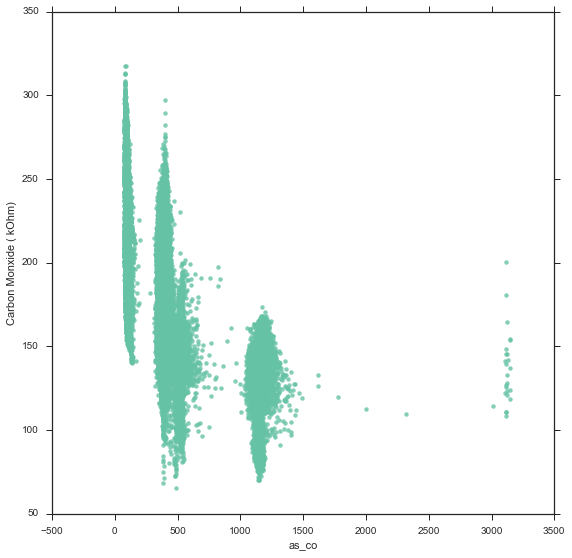

In [467]:
x_col= 'as_co'
y_col= 'Carbon Monxide ( kOhm)'

fig, ax = plt.subplots(figsize=(9,9))
sns.regplot(x_col, y_col, data=fullset, fit_reg=False)
#plt.ylim(0,1)
#plt.xlim(0,1)

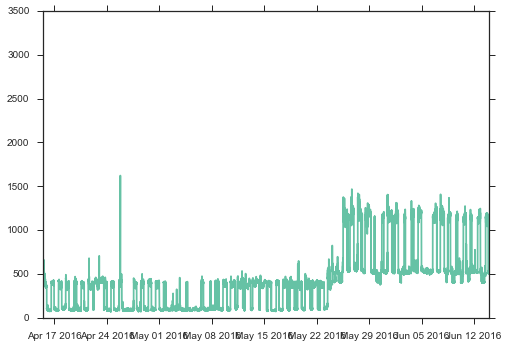

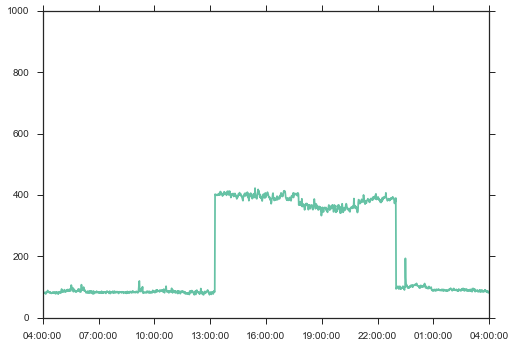

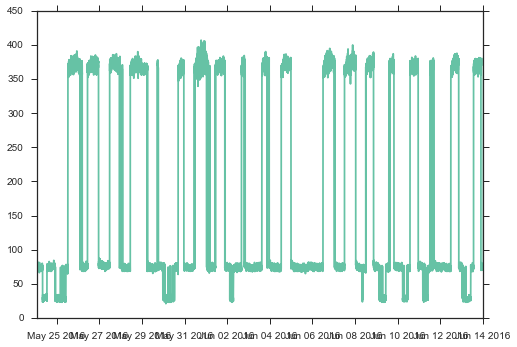

In [468]:
fig, ax = plt.subplots()
plt.plot(fullset.index.values, fullset['as_co'])
#plt.ylim(0,1000)

starttime = datetime.datetime(2016,4,20)
endtime = datetime.datetime(2016,4,21)

fig, ax = plt.subplots()
plt.plot(fullset.ix[starttime:endtime].index.values, fullset.ix[starttime:endtime]['as_co'])
plt.ylim(0,1000)


fig, ax = plt.subplots()
plt.plot(fullset.index.values, fullset['as_no2'])
#plt.ylim(0,1000)

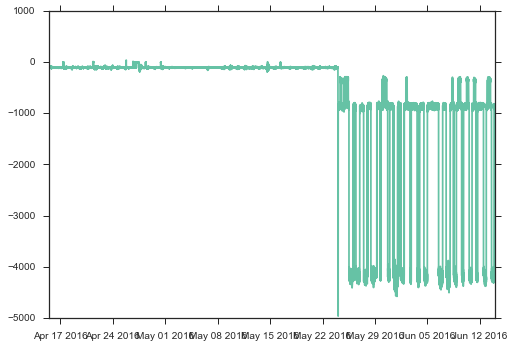

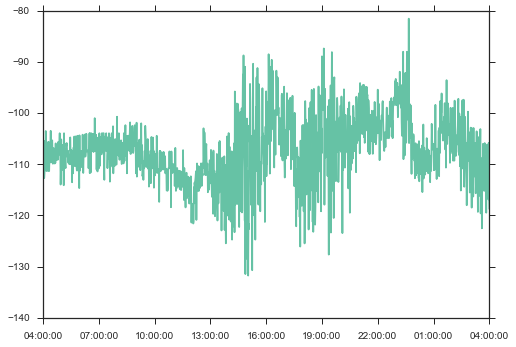

In [469]:
fig, ax = plt.subplots()
plt.plot(fullset.index.values, fullset['as_o3'])


starttime = datetime.datetime(2016,4,20)
endtime = datetime.datetime(2016,4,21)

fig, ax = plt.subplots()
plt.plot(fullset.ix[starttime:endtime].index.values, fullset.ix[starttime:endtime]['as_o3'])


In [470]:
#full ml array
fullset.to_pickle('full_mlarray.pkl')
print len(fullset)

85739
